# Tutorial - Wind Power Prediction Using Gaussian Processes

***Machine Learning for Renewable Energy Systems***

**Timo Lübbing**

**University of Tübingen**

## Introduction

This tutorial explores the application of Gaussian Processes (GP) in forecasting wind power generation. Through a series of code examples and explanations, you'll gain insights into data preprocessing, feature engineering, and the training and evaluation of GP models for wind energy prediction.

We'll also delve into forecasting the combined output of off-shore and on-shore wind power. Additionally, we'll examine how different weather input features influence the model's performance, providing a deeper understanding of their impact on predictive accuracy.

In [14]:
import sys
import pandas as pd
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LassoCV

sys.path.append(str(Path("..").resolve()))
from src.visualizations import (
    setup_tueplots,
    plot_wind_power_composition,
    plot_wind_speed_components,
)
from src.preprocessing import (
    Column,
    preprocess_supply_data,
    weather_germany_mean,
    weather_germany_clustered,
    create_time_features,
    create_sliding_window_data,
)
from src.checkpoint import save_checkpoint, load_checkpoint

In [15]:
path = Path('..') / 'data' / 'Realised_Supply_Germany.csv'
df = pd.read_csv(path, sep=';', decimal=',')

In [16]:
df = preprocess_supply_data(df, resample="h")

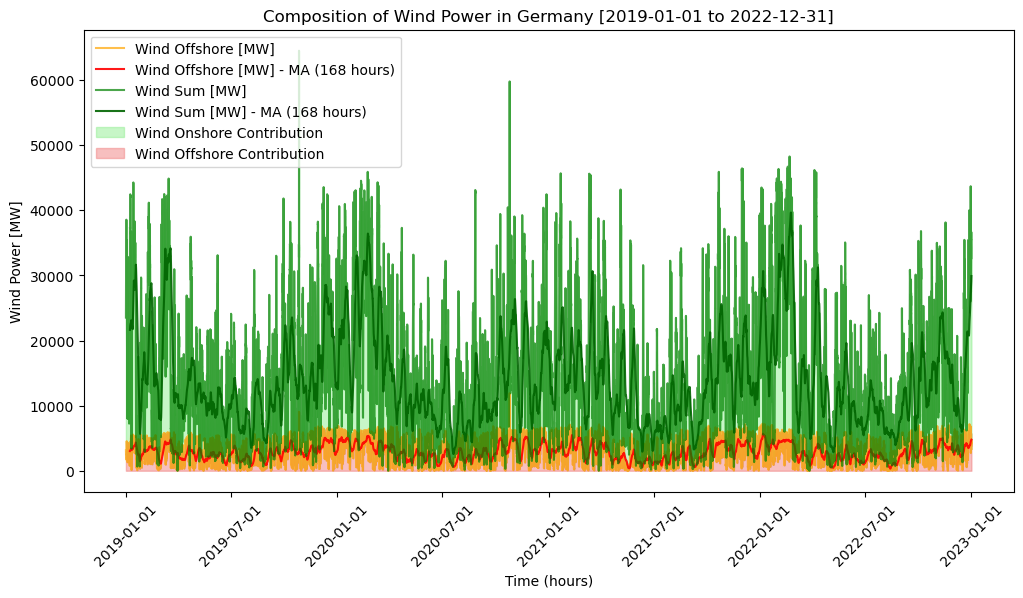

In [17]:
fig = plot_wind_power_composition(
    dates=df.index,
    wind_offshore=df[Column.WIND_OFFSHORE.value],
    wind_onshore=df[Column.WIND_ONSHORE.value],
    moving_average_window=24*7
)

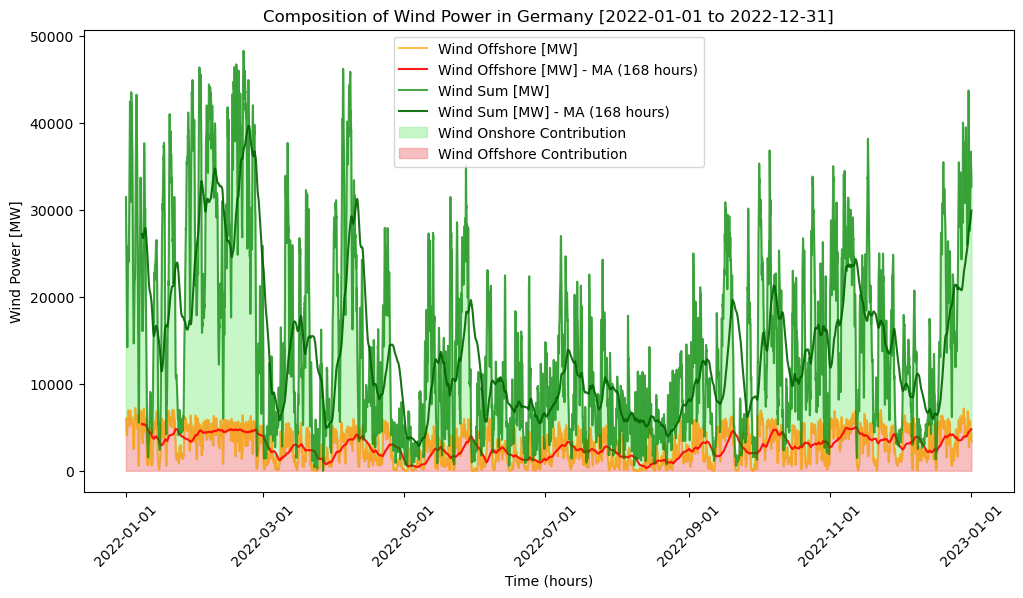

In [18]:
# df_indexed = df["2022-01-01":"2022-12-31"]
df_indexed = df["2022-01-01":"2022-12-31"]
wind_offshore_2022 = df_indexed[Column.WIND_OFFSHORE.value]
wind_onshore_2022 = df_indexed[Column.WIND_ONSHORE.value]
dates_2022 = df_indexed.index

fig = plot_wind_power_composition(
    dates_2022, wind_offshore_2022, wind_onshore_2022, 24*7,
)

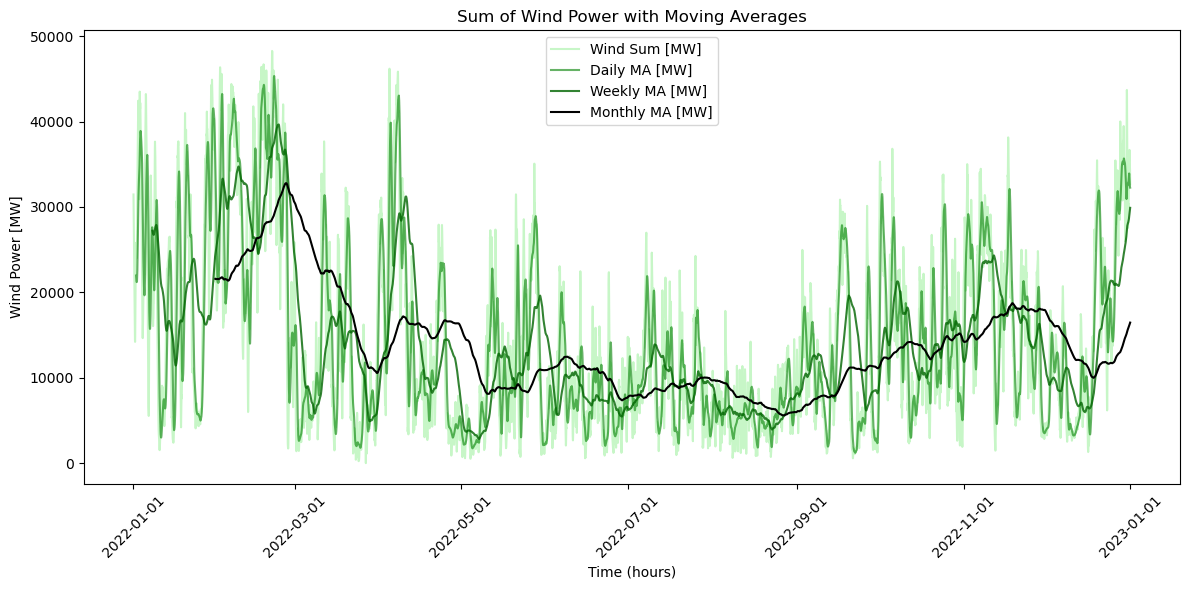

In [19]:
wind = df_indexed[Column.WIND.value]
dates = df_indexed.index

# Calculate moving averages
wind_daily_ma = wind.rolling(window=24).mean()
wind_weekly_ma = wind.rolling(window=24*7).mean()
wind_monthly_ma = wind.rolling(window=24*30).mean()

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
locator = ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator=locator))

ax.plot(dates, wind, label="Wind Sum [MW]", color="lightgreen", alpha=0.5)
ax.plot(dates, wind_daily_ma, label="Daily MA [MW]", color="green", alpha=0.6)
ax.plot(dates, wind_weekly_ma, label="Weekly MA [MW]", color="darkgreen", alpha=0.8)
ax.plot(dates, wind_monthly_ma, label="Monthly MA [MW]", color="black", alpha=1)

ax.set_title("Sum of Wind Power with Moving Averages")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Wind Power [MW]")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
weather_path = Path('..') / "data" / "Weather_Data_Germany.csv"
weather_2022_path = Path('..') / "data" / "Weather_Data_Germany_2022.csv"
weather = pd.read_csv(weather_path, sep=',', decimal='.')
weather_2022 = pd.read_csv(weather_2022_path, sep=',', decimal='.')

weather.head(2)

,longitude,latitude,forecast_origin,time,cdir,z,msl,blh,tcc,u10,v10,t2m,ssr,tsr,sund,tp,fsr,u100,v100
0,5.8,54.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,-2.766602,102439.914,766.03015,0.304399,11.806978,2.823900,282.04110,0.0,0.0,0.0,0.0,0.000860,15.666069,3.153420
1,5.8,53.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,-6.159180,102795.230,842.93190,0.945699,6.628730,1.767059,281.28223,0.0,0.0,0.0,0.0,0.254992,10.824787,2.401394


In [21]:
def format_weather_time(weather: pd.DataFrame) -> None:
    """Formats weather data time column and sets it as index."""
    weather.drop(columns=["forecast_origin"], inplace=True)
    weather["time"] = pd.to_datetime(weather["time"], format="%Y-%m-%d %H:%M:%S")
    weather.set_index("time", inplace=True)
    weather.sort_index(inplace=True)

format_weather_time(weather)
format_weather_time(weather_2022)

weather = pd.concat([weather, weather_2022], axis=0)

In [22]:
# Select preprocessing method:
# 1. mean weather data across Germany
# 2. cluesterd mean weather data (keep parts of location information)

k_clusters = 5
use_clustering = False  # Default: False to reduce complexity

if use_clustering:
    weather = weather_germany_clustered(weather, k_clusters=k_clusters)
else:
    weather = weather_germany_mean(weather)

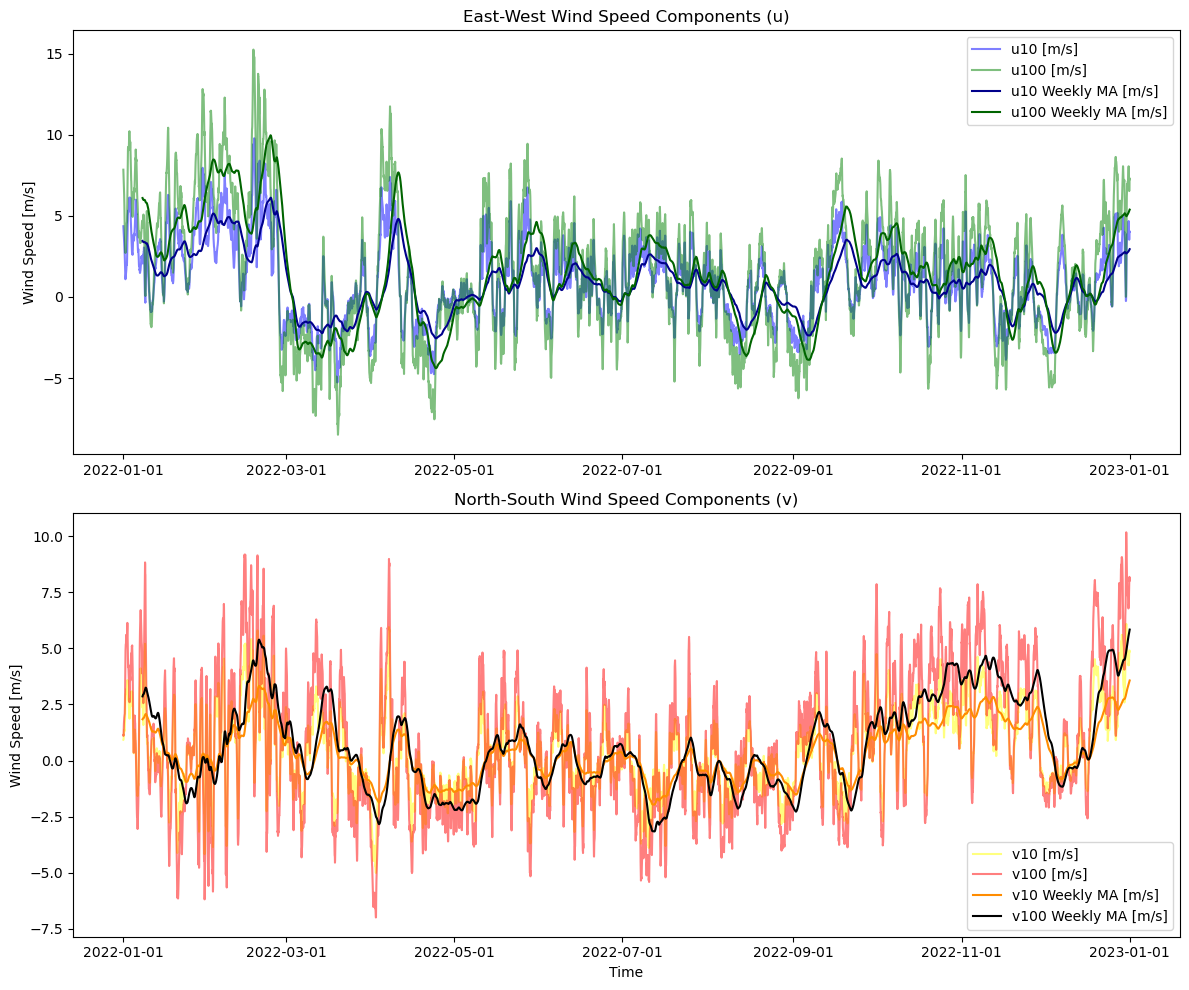

In [23]:
weather_indexed = weather["2022-01-01":"2022-12-31"]
plot_wind_speed_components(weather_indexed)

### Machine Learning Setup for Forecasting
- Split data into training and testing sets
- Sliding window approach for time series forecasting
- Feature engineering
   - Create lag features
   - Use weather data as additional features
- Feature selection
   - Select relevant features based on correlation with target variable
   - Mutual Information, Pearson Correlation, Autocorrelation
   - Fit a Lasso regression model and select features based on coefficients (try LassoCV)

In [24]:
# Join weather data with wind data
target = df[[Column.WIND.value]].copy()
dataframe = target.join(weather, how="inner")

# Create time features
dataframe = create_time_features(dataframe)

In [25]:
# Train and test split
SPLIT_DATE = "2022-01-01"
START_DATE = df.index[0]
END_DATE = df.index[-1]

train_data = dataframe[START_DATE:SPLIT_DATE]
test_data = dataframe[SPLIT_DATE:END_DATE]

In [28]:
# Scale target variable
target_scaler = StandardScaler()
train_data.loc[:, [Column.WIND.value]] = target_scaler.fit_transform(
    train_data.loc[:, [Column.WIND.value]]
)
test_data.loc[:, [Column.WIND.value]] = target_scaler.transform(
    test_data.loc[:, [Column.WIND.value]]
)

In [29]:
X_df, y_df = create_sliding_window_data(
    data=train_data,
    history=24,
    forecast_horizon=24,
)
X_test_df, y_test_df = create_sliding_window_data(
    data=test_data,
    history=24,
    forecast_horizon=24,
)
print(X_df.columns)

Index(['lag_24', 'lag_23', 'lag_22', 'lag_21', 'lag_20', 'lag_19', 'lag_18',
       'lag_17', 'lag_16', 'lag_15', 'lag_14', 'lag_13', 'lag_12', 'lag_11',
       'lag_10', 'lag_9', 'lag_8', 'lag_7', 'lag_6', 'lag_5', 'lag_4', 'lag_3',
       'lag_2', 'lag_1', 'cdir', 'z', 'msl', 'blh', 'tcc', 'u10', 'v10', 't2m',
       'ssr', 'tsr', 'sund', 'tp', 'fsr', 'u100', 'v100', 'hour_sin',
       'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos',
       'dayofyear_sin', 'dayofyear_cos'],
      dtype='object')
